In [24]:
from __future__ import print_function
import numpy as np
import pandas as pd
import copy

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [3]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [4]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [5]:
len(ef)

61532

In [6]:
F = (ef['use_record'] == 1)

In [7]:
ef = ef.loc[F]
len(ef)

9320

In [9]:
ef.ea_lv_systolic.value_counts()

 0.0    2297
-1.0     308
 3.0     220
 1.0     183
 2.0     147
-2.0      71
-3.0      30
Name: ea_lv_systolic, dtype: int64

## Extract the echo features table and time of death

In [21]:
had_echo = ~np.isnan(ef.ea_key)
sum(had_echo)

3686

In [34]:
tod = ef.dod - ef.intime

In [10]:
cols = [col for col in ef.columns if col.startswith('ea_')]

In [27]:
features = copy.copy(cols)
features.remove('ea_hadm_id')
features.remove('ea_new_time')
features.remove('ea_key')
features.remove('ea_height')
features.remove('ea_weight')
features.remove('ea_sys')
features.remove('ea_diastolic')
features.remove('ea_hr')

In [29]:
for name in features:
    print(name, ef[name].unique())

ea_tv_pulm_htn [  1.  nan  -3.   3.   0.   2. -50.]
ea_tv_regurgitation [  0.  nan  -3.   3.   1.   2.  -2. -50.]
ea_tv_stenosis [  0.  nan  -3.   1.   2.]
ea_lv_cavity [  0.  nan  -1.   2.   3.   1.  -3.  -2. -50.]
ea_lv_diastolic [  0.  nan  -2.   3.   2.  -3.   1.]
ea_lv_systolic [  2.  nan   0.  -2.  -1.   1.   3.  -3.]
ea_lv_wall [  0.  nan   1.   2.   3.  -2.  -3.]
ea_rv_cavity [  0.  nan  -2.   2.   1.  -1.  -3. -50.]
ea_rv_volume_overload [ nan  -3.   1.]
ea_rv_systolic [  0.  nan   2.   1.   3.  -2.  -3. -50.]
ea_rv_wall [ nan  -3.   0.   1.]
ea_av_regurgitation [  0.  nan   1.   2.   3.  -3.  -2.]
ea_av_stenosis [  0.  nan   1.   3.   2.  -3.  -2.]
ea_mv_regurgitation [  0.  nan   1.  -2.   2.   3. -50.]
ea_mv_stenosis [  0.  nan  -3.   1.   2.]
ea_la_cavity [  0.  nan   2.   1.  -2.   3.  -3. -50.]
ea_ra_dilated [  0.  nan   1.]
ea_ra_pressure [ nan   0.  -3.   2.   1.]


In [31]:
X = ef[features].copy()
X[np.isnan(X)] = -9
X = X.astype(np.int32)

In [32]:
for name in features:
    print(name, X[name].unique())

ea_tv_pulm_htn [  1  -9  -3   3   0   2 -50]
ea_tv_regurgitation [  0  -9  -3   3   1   2  -2 -50]
ea_tv_stenosis [ 0 -9 -3  1  2]
ea_lv_cavity [  0  -9  -1   2   3   1  -3  -2 -50]
ea_lv_diastolic [ 0 -9 -2  3  2 -3  1]
ea_lv_systolic [ 2 -9  0 -2 -1  1  3 -3]
ea_lv_wall [ 0 -9  1  2  3 -2 -3]
ea_rv_cavity [  0  -9  -2   2   1  -1  -3 -50]
ea_rv_volume_overload [-9 -3  1]
ea_rv_systolic [  0  -9   2   1   3  -2  -3 -50]
ea_rv_wall [-9 -3  0  1]
ea_av_regurgitation [ 0 -9  1  2  3 -3 -2]
ea_av_stenosis [ 0 -9  1  3  2 -3 -2]
ea_mv_regurgitation [  0  -9   1  -2   2   3 -50]
ea_mv_stenosis [ 0 -9 -3  1  2]
ea_la_cavity [  0  -9   2   1  -2   3  -3 -50]
ea_ra_dilated [ 0 -9  1]
ea_ra_pressure [-9  0 -3  2  1]


In [37]:
for name in features:
    print(name, X.loc[had_echo][name].unique())

ea_tv_pulm_htn [  1  -9  -3   3   0   2 -50]
ea_tv_regurgitation [  0  -9  -3   3   1   2  -2 -50]
ea_tv_stenosis [ 0 -9 -3  1  2]
ea_lv_cavity [  0  -9  -1   2   3   1  -3  -2 -50]
ea_lv_diastolic [ 0 -9 -2  3  2 -3  1]
ea_lv_systolic [ 2  0 -2 -9 -1  1  3 -3]
ea_lv_wall [ 0  1 -9  2  3 -2 -3]
ea_rv_cavity [  0  -2   2   1  -9  -1  -3 -50]
ea_rv_volume_overload [-9 -3  1]
ea_rv_systolic [  0  -9   2   1   3  -2  -3 -50]
ea_rv_wall [-9 -3  0  1]
ea_av_regurgitation [ 0  1 -9  2  3 -3 -2]
ea_av_stenosis [ 0 -9  1  3  2 -3 -2]
ea_mv_regurgitation [  0  -9   1  -2   2   3 -50]
ea_mv_stenosis [ 0 -9 -3  1  2]
ea_la_cavity [  0  -9   2   1  -2   3  -3 -50]
ea_ra_dilated [ 0  1 -9]
ea_ra_pressure [-9  0 -3  2  1]


In [36]:
y = tod < np.timedelta64(30, 'D')
y.mean()

0.2811158798283262

## Pairwise mutual information between echo features and outcome

In [38]:
from collections import Counter

In [75]:
def mutual_information(x, y):
    px = x.value_counts()
    px /= px.sum()
    py = y.value_counts()
    py /= py.sum()
    pxy = pd.Series(zip(x, y)).value_counts()
    pxy /= pxy.sum()
    
    MI = 0
    for v1, v2 in pxy.index:
        MI += pxy[(v1,v2)]*(np.log(pxy[(v1,v2)]) - np.log(px[v1]) - np.log(py[v2]))
    return MI
    

In [76]:
def pairwise_MI(x):
    MI = {}
    columns = x.columns
    for i in range(len(columns)):
        k1 = columns[i]
        for j in range(i, len(columns)):
            k2 = columns[j]
            pMI = mutual_information(x[k1], x[k2])
            d = MI.get(k1, {})
            d[k2] = pMI
            MI[k1] = d
            d = MI.get(k2, {})
            d[k1] = pMI
            MI[k2] = d
    return pd.DataFrame(MI)


In [77]:
mutual_info = pairwise_MI(X.loc[had_echo])

In [78]:
mutual_info

,ea_av_regurgitation,ea_av_stenosis,ea_la_cavity,ea_lv_cavity,ea_lv_diastolic,ea_lv_systolic,ea_lv_wall,ea_mv_regurgitation,ea_mv_stenosis,ea_ra_dilated,ea_ra_pressure,ea_rv_cavity,ea_rv_systolic,ea_rv_volume_overload,ea_rv_wall,ea_tv_pulm_htn,ea_tv_regurgitation,ea_tv_stenosis
ea_av_regurgitation,1.142125,0.148522,0.053263,0.029501,0.015605,0.022270,0.046235,0.121585,0.038405,0.023631,0.007572,0.022865,0.028220,0.001806,0.003164,0.056177,0.069749,0.028381
ea_av_stenosis,0.148522,0.963050,0.055912,0.030310,0.025060,0.022313,0.069378,0.065738,0.060144,0.018748,0.011404,0.021316,0.031588,0.002784,0.004594,0.070689,0.048536,0.035148
ea_la_cavity,0.053263,0.055912,1.514633,0.094403,0.019562,0.027715,0.104597,0.067110,0.026003,0.224955,0.007914,0.050771,0.031523,0.006960,0.009897,0.084506,0.091616,0.034144
ea_lv_cavity,0.029501,0.030310,0.094403,0.736036,0.022665,0.099005,0.168293,0.037266,0.013591,0.051231,0.005434,0.042725,0.034318,0.009355,0.011540,0.039869,0.037581,0.016239
ea_lv_diastolic,0.015605,0.025060,0.019562,0.022665,0.486990,0.019392,0.034317,0.016907,0.014892,0.005099,0.006533,0.011845,0.012048,0.006694,0.010237,0.014985,0.017946,0.009965
ea_lv_systolic,0.022270,0.022313,0.027715,0.099005,0.019392,1.313811,0.039944,0.066808,0.022309,0.013222,0.004014,0.031466,0.093946,0.005497,0.017847,0.013452,0.044724,0.020808
ea_lv_wall,0.046235,0.069378,0.104597,0.168293,0.034317,0.039944,1.145711,0.034300,0.029355,0.051662,0.006773,0.035671,0.034027,0.004730,0.014149,0.061345,0.057683,0.029559
ea_mv_regurgitation,0.121585,0.065738,0.067110,0.037266,0.016907,0.066808,0.034300,1.462400,0.083371,0.032755,0.007223,0.025629,0.039273,0.005375,0.007794,0.078496,0.153249,0.027749
ea_mv_stenosis,0.038405,0.060144,0.026003,0.013591,0.014892,0.022309,0.029355,0.083371,0.752349,0.005202,0.002056,0.013197,0.017069,0.004149,0.003347,0.026311,0.035377,0.075390
ea_ra_dilated,0.023631,0.018748,0.224955,0.051231,0.005099,0.013222,0.051662,0.032755,0.005202,1.094057,0.033832,0.048443,0.030760,0.012766,0.015195,0.050392,0.060325,0.011491


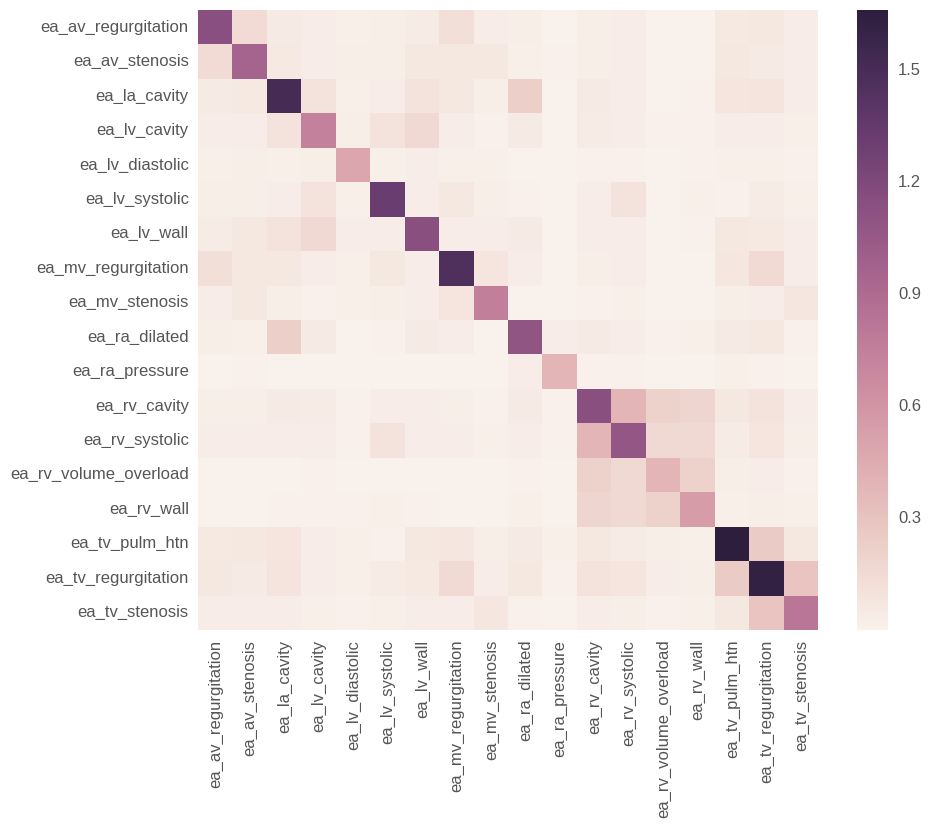

In [74]:
#g = sns.clustermap(mutual_info, row_linkage=Z, col_linkage=Z)
#_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation = 0)
_,ax = plt.subplots(1, figsize=(10,8))
g = sns.heatmap(mutual_info, ax=ax)
_ = g.set_yticklabels(g.get_yticklabels(), rotation = 0)

In [84]:
outcome_MI = X.apply(lambda x: mutual_information(x, y.loc[had_echo]), axis=0)
outcome_MI.sort_values(ascending=False)

ea_la_cavity             0.001529
ea_tv_regurgitation      0.001345
ea_tv_pulm_htn           0.001318
ea_lv_wall               0.001312
ea_av_regurgitation      0.001247
ea_rv_cavity             0.001093
ea_lv_diastolic          0.001075
ea_rv_systolic           0.001000
ea_mv_stenosis           0.000962
ea_mv_regurgitation      0.000630
ea_lv_cavity             0.000626
ea_av_stenosis           0.000578
ea_lv_systolic           0.000556
ea_tv_stenosis           0.000498
ea_rv_wall               0.000393
ea_ra_dilated            0.000188
ea_ra_pressure           0.000175
ea_rv_volume_overload    0.000145
dtype: float64

In [87]:
X_dummy = pd.get_dummies(ef[features].loc[had_echo].apply(lambda x: x.astype('category'), axis=0))
X_dummy.head()

,ea_tv_pulm_htn_-50.0,ea_tv_pulm_htn_-3.0,ea_tv_pulm_htn_0.0,ea_tv_pulm_htn_1.0,ea_tv_pulm_htn_2.0,ea_tv_pulm_htn_3.0,ea_tv_regurgitation_-50.0,ea_tv_regurgitation_-3.0,ea_tv_regurgitation_-2.0,ea_tv_regurgitation_0.0,...,ea_la_cavity_0.0,ea_la_cavity_1.0,ea_la_cavity_2.0,ea_la_cavity_3.0,ea_ra_dilated_0.0,ea_ra_dilated_1.0,ea_ra_pressure_-3.0,ea_ra_pressure_0.0,ea_ra_pressure_1.0,ea_ra_pressure_2.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
60,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
68,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
from sklearn.model_selection import train_test_split

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y.loc[had_echo], test_size=0.2, random_state=0)

## Try naive Bayes classifier with binarized variables

In [94]:
from sklearn.naive_bayes import BernoulliNB

In [109]:
nb = BernoulliNB()

In [110]:
nb.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [111]:
np.exp(nb.class_log_prior_)

array([ 0.70251018,  0.29748982])

In [112]:
y_train.mean()

0.2974898236092266

In [113]:
y_train_proba = nb.predict_proba(X_train)

In [118]:
np.mean(np.argmax(y_train_proba, axis=1) == y_train)

0.65569877883310723

In [126]:
nb.score(X_test, y_test)

0.65311653116531165

## Logistic regression

In [119]:
from sklearn.linear_model import LogisticRegression

In [120]:
lm = LogisticRegression()

In [121]:
lm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [122]:
lm.score(X_train, y_train)

0.71336499321573943

In [123]:
lm.score(X_test, y_test)

0.69376693766937669

In [125]:
y_test.mean()

0.2872628726287263

In [139]:
from sklearn.metrics import precision_recall_curve, roc_curve

In [170]:
y_prob_test = lm.predict_proba(X_test)

In [171]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test[:,1])

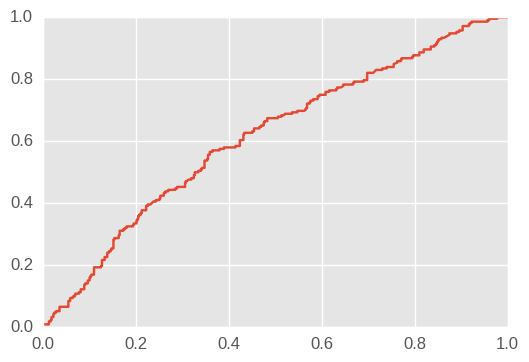

In [172]:
plt.plot(fpr, tpr)

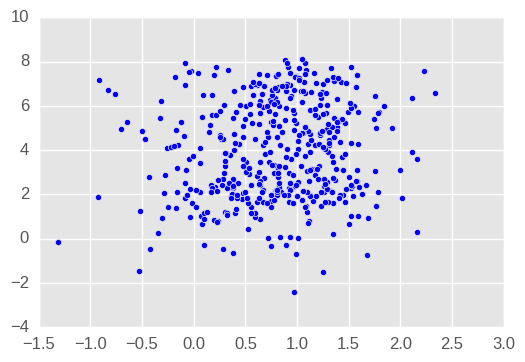

In [173]:
plt.scatter(np.log(y_prob_test[:,0]/y_prob_test[:,1]), np.log(tod.loc[y_test.index]/np.timedelta64(1, 'D')))

## Random forest classifier

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [128]:
rfc = RandomForestClassifier()

In [129]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [130]:
rfc.score(X_train, y_train)

0.95386702849389415

In [131]:
rfc.score(X_test, y_test)

0.67344173441734423

## Support vector machine

In [132]:
from sklearn.svm import SVC

In [133]:
svm = SVC(kernel='linear', C=1)

In [134]:
svm.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [135]:
svm.score(X_train, y_train)

0.70624151967435544

In [137]:
svm.score(X_test, y_test)

0.7032520325203252

In [161]:
svm = SVC(kernel='rbf', C=1, probability=True)

In [162]:
svm.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [163]:
svm.score(X_train, y_train)

0.7025101763907734

In [164]:
svm.score(X_test, y_test)

0.7127371273712737

In [165]:
svm.predict_proba(X_test)

array([[ 0.68518059,  0.31481941],
       [ 0.71742622,  0.28257378],
       [ 0.7208568 ,  0.2791432 ],
       ..., 
       [ 0.68358064,  0.31641936],
       [ 0.72081855,  0.27918145],
       [ 0.71803863,  0.28196137]])

In [166]:
y_prob_test = svm.predict_proba(X_test)

In [167]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test[:,1])

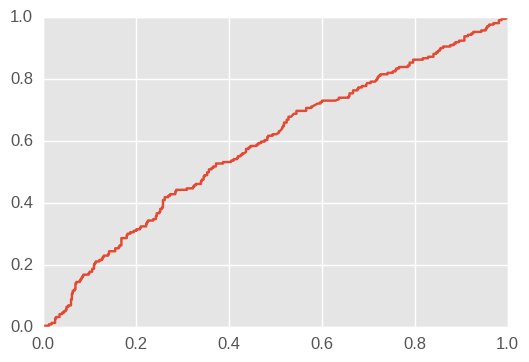

In [168]:
plt.plot(fpr, tpr)

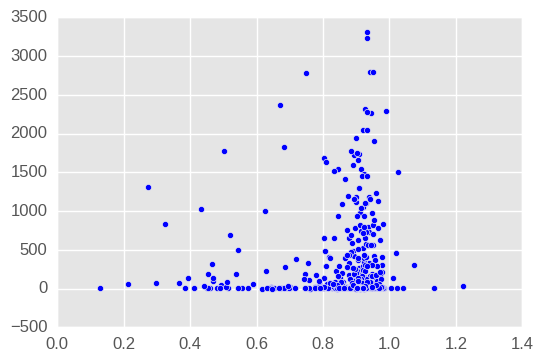

In [169]:
plt.scatter(np.log(y_prob_test[:,0]/y_prob_test[:,1]), tod.loc[y_test.index]/np.timedelta64(1, 'D'))

The echo variables alone don't seem to be predictive of mortality. What about including some demographic info?

## Include some demographics

In [176]:
age = ef['age']/np.timedelta64(1, 'Y')
age_observed = age > 0

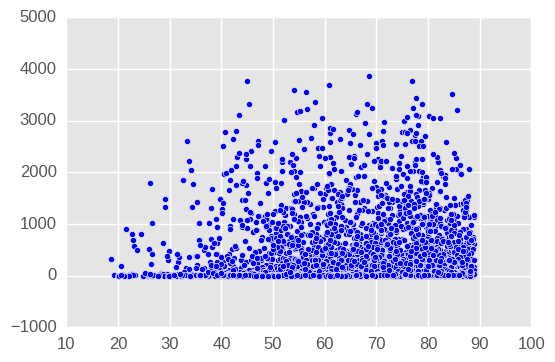

In [181]:
plt.scatter(age.loc[age_observed], tod.loc[age_observed]/np.timedelta64(1, 'D'))

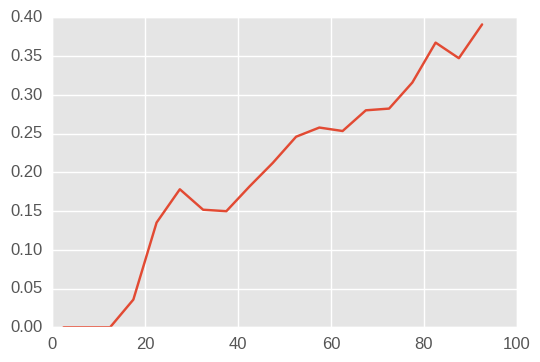

In [207]:
bins = pd.cut(age.loc[age_observed], np.arange(0,91,5), labels=False)
frac = np.zeros(len(np.arange(0,91,5)))
for i in range(len(frac)):
    if i == len(frac)-1:
        frac[i] = (tod.loc[~age_observed] < np.timedelta64(30, 'D')).mean()
    else:
        j = bins.loc[bins == i]
        if len(j) > 0:
            frac[i] = (tod.loc[j.index] < np.timedelta64(30, 'D')).mean()
plt.plot(np.arange(2.5,95,5), frac)

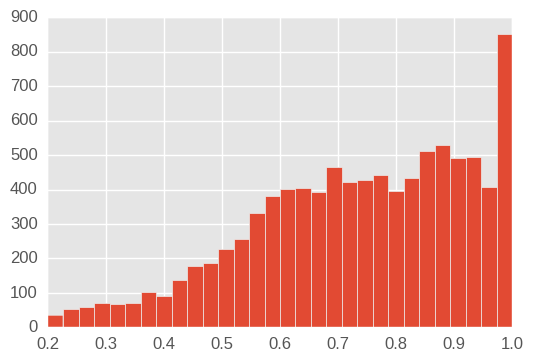

In [211]:
age_scaled = age/90
age_scaled.loc[~age_observed] = 1.0
_ = plt.hist(age_scaled, bins=30)

In [213]:
gender = ef['gender']
gender.head()

1     M
16    F
20    M
22    M
25    M
Name: gender, dtype: object

In [215]:
gender = (gender == 'F')

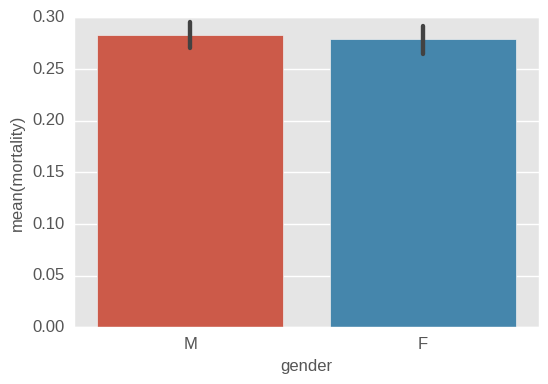

In [217]:
sns.barplot(data=pd.DataFrame({'gender': ef['gender'], 'mortality': tod < np.timedelta64(30, 'D')})
            , x='gender', y='mortality')

In [138]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
for train, test in StratifiedKFold(n_splits=10).split(X_train, y_train):
    Xt = X_train.iloc[train]
    yt = y_train.iloc[train]
    Xv = X_train.iloc[test]
    yv = y_train.iloc[test]
    
    
    